### Approximating the Integral from the equation

In [7]:
def integral(f, t1, t2, dt=0.1):
    # area begins at 0.0 
    area = 0.0
    
    # t starts at the lower bound of integration
    t = t1
    
    # integration continues until we reach upper bound
    while t < t2:
        
        # calculate the TINY bit of area associated with
        # this particular rectangle and add to total
        dA = f(t) * dt
        area += dA
        t += dt
    return area

$$\int_{-2}^2 3t^3 - 4t dt$$

In [8]:
# Your code here

def f3(t):
    return 3*t**3 - 4*t

integral(f3, -2, 2, 0.0001)

-6.485876072326313e-12

### Approximating the Integral from data

In [16]:
from src.helpers import process_data, get_derivative_from_data
from matplotlib import pyplot as plt

PARALLEL_PARK_DATA = process_data("./data/parallel_park.pickle")

TIMESTAMPS    = [row[0] for row in PARALLEL_PARK_DATA]
DISPLACEMENTS = [row[1] for row in PARALLEL_PARK_DATA]
YAW_RATES     = [row[2] for row in PARALLEL_PARK_DATA]
ACCELERATIONS = [row[3] for row in PARALLEL_PARK_DATA]

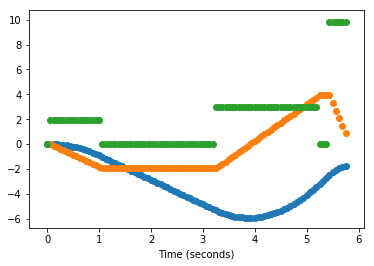

In [25]:
speeds = get_derivative_from_data(DISPLACEMENTS, TIMESTAMPS)
accels = get_derivative_from_data(speeds, TIMESTAMPS[1:])
# You saw this plot of displacement versus time.

plt.xlabel("Time (seconds)")
plt.scatter(TIMESTAMPS, DISPLACEMENTS)
plt.scatter(TIMESTAMPS[1:], speeds)
plt.scatter(TIMESTAMPS, ACCELERATIONS)
plt.show()

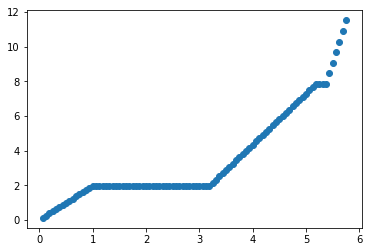

In [28]:
def get_integral_from_data(acceleration_data, times):
    # 1. We will need to keep track of the total accumulated speed
    accumulated_speed = 0.0
    
    # 2. The next lines should look familiar from the derivative code
    last_time = times[0]
    speeds = []
    
    # 3. Once again, we lose some data because we have to start
    #    at i=1 instead of i=0.
    for i in range(1, len(times)):
        
        # 4. Get the numbers for this index i
        acceleration = acceleration_data[i]
        time = times[i]
        
        # 5. Calculate delta t
        delta_t = time - last_time
        
        # 6. This is an important step! This is where we approximate
        #    the area under the curve using a rectangle w/ width of
        #    delta_t.
        delta_v = acceleration * delta_t
        
        # 7. The actual speed now is whatever the speed was before
        #    plus the new change in speed.
        accumulated_speed += delta_v
        
        # 8. append to speeds and update last_time
        speeds.append(accumulated_speed)
        last_time = time
    return speeds

# 9. Now we use the function we just defined
integrated_speeds = get_integral_from_data(ACCELERATIONS, TIMESTAMPS)

# 10. Plot
plt.scatter(TIMESTAMPS[1:], integrated_speeds)
plt.show()

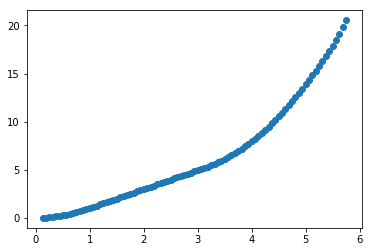

In [27]:
# Integrate AGAIN! Let's see what happens when we integrate 
# again to get displacement data...

integrated_displacements = get_integral_from_data(integrated_speeds, 
                                                 TIMESTAMPS[1:])
plt.scatter(TIMESTAMPS[2:], integrated_displacements)
plt.show()

### Rate Gyros 

to figure out the vehicle's heading(yaw)

In [30]:
from src.helpers import process_data, get_derivative_from_data
from matplotlib import pyplot as plt

PARALLEL_PARK_DATA = process_data("./data/parallel_park.pickle")

TIMESTAMPS    = [row[0] for row in PARALLEL_PARK_DATA]
DISPLACEMENTS = [row[1] for row in PARALLEL_PARK_DATA]
YAW_RATES     = [row[2] for row in PARALLEL_PARK_DATA]
ACCELERATIONS = [row[3] for row in PARALLEL_PARK_DATA]

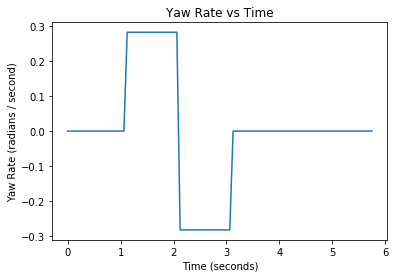

In [31]:
plt.title("Yaw Rate vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Yaw Rate (radians / second)")
plt.plot(TIMESTAMPS, YAW_RATES)
plt.show()

Here's what I make of this data

**From t=0 to t=1**: The yaw rate is zero so the wheels are straight (or the car isn't moving). This is when the car is backing up straight.

**From t=1 to t=2**: This is where the driver cuts the steering wheel hard to the right and keeps backing up. Since the yaw rate is non-zero, this means the vehicle is turning.

**From t=2 to t=3**: This is where the driver cuts the wheel back to the left to straighten out. 

**After t=3**: Here the vehicle isn't turning so it's probably just adjusting its position within the spot by driving forward and/or backward slowly.

In [32]:
def get_integral_from_data(data, times):
    heading = []
    
    prev_time = times[0]

    yaw = 0.
    
    for i in range(1, len(times)):
        delta_t = times[i] - prev_time
        
        delta_yaw = data[i]*delta_t
        yaw += delta_yaw
        
        heading.append(yaw)
        
        prev_time = times[i] 
    
    return heading


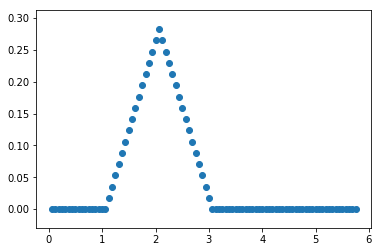

In [33]:
# Visual Testing - Compare the result of your 
# integration code to the plot above

thetas = get_integral_from_data(YAW_RATES, TIMESTAMPS)

plt.scatter(TIMESTAMPS[1:], thetas)
plt.show()

### Accumulating Errors
Accelerometers are often **biased**. That means that even when acceleration is zero, they measure some non-zero value. Bias can be reduced through careful calibration (and buying better sensors) but it's hard to remove entirely.

In this notebook you'll briefly explore how bias tends to accumulate.

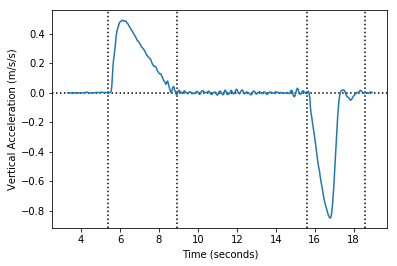

In [35]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# get elevator data
data = np.genfromtxt("./data/elevator-lac.csv", delimiter=",")[100:570]

# unpack that data
t, a_x, a_y, a_z = data.T
plt.ylabel("Vertical Acceleration (m/s/s)")
plt.xlabel("Time (seconds)")
region_delimiters = [5.4, 8.9, 15.6, 18.6]
for x_val in region_delimiters:
    plt.axvline(x=x_val, color="black",linestyle='dotted')

plt.axhline(y=0, color='black',linestyle='dotted')
plt.plot(t, a_z + 0.12) # to correct the bias 
plt.show()

#### Rewriting `get_integral_from_data` with bias

In the code cell below you will see how I've rewritten this function to include an **optional** third parameter called `bias`. The default value for this parameter is zero.

When this parameter is non-zero, it simulates (or corrects) an offset in the data.

In [36]:
def get_integral_from_data(acceleration_data, times, bias=0.0):
    """
    Numerically integrates data AND artificially introduces 
    bias to that data.
    
    Note that the bias parameter can also be used to offset
    a biased sensor.
    """
    accumulated_speed = 0.0
    last_time = times[0]
    speeds = []
    for i in range(1, len(times)):
        
        # THIS is where the bias is introduced. No matter what the 
        # real acceleration is, this biased accelerometer adds 
        # some bias to the reported value.
        acceleration = acceleration_data[i] + bias
        
        time = times[i]
        delta_t = time - last_time
        delta_v = acceleration * delta_t
        accumulated_speed += delta_v
        speeds.append(accumulated_speed)
        last_time = time
    return speeds

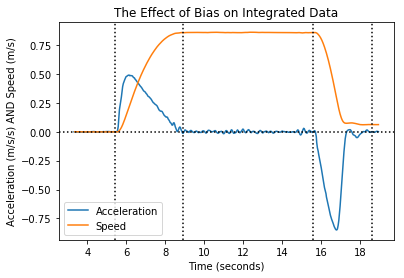

In [37]:
# TODO 
#   0. read through the code below to get a sense for what it does.
#   1. run this cell with OFFSET = 0.0
#   2. look at the graph. Note how drastic the error is with the
#      integrated speed! 
#   3. change OFFSET to OFFSET = 0.12 and re-run the cell

OFFSET = 0.12

plt.title("The Effect of Bias on Integrated Data")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (m/s/s) AND Speed (m/s)")

# get the elevator speeds by integrating the acceleration data
elevator_speeds = get_integral_from_data(a_z, t, OFFSET)

# plot acceleration data
plt.plot(t, a_z+OFFSET) 

# plot INFERRED (from integration) speed data
plt.plot(t[1:], elevator_speeds)

# add a legend to the plot
plt.legend(["Acceleration", "Speed"])

# vertical lines
region_delimiters = [5.4, 8.9, 15.6, 18.6]
for x_val in region_delimiters:
    plt.axvline(x=x_val, color="black",linestyle='dotted')

# a=0 reference line
plt.axhline(y=0, color='black',linestyle='dotted')

plt.show()

When `OFFSET = 0.0`, the speed graph looks absurd! It says that the speed of the elevator at the end of the journey is $-1.8$ m/s (clearly it should be 0.0). 

And note that the effect of bias gets worse (for the speed graph) as time goes on! 

When `OFFSET = 0.12` this graph looks much more reasonable (though still not perfect).

> We should be more suspicious of integrated data when the integrations happen over a long period of time. 

####  The Effect of Repeated Integration

You saw that bias has a bigger impact on integrated data when we give that data time to accumulate. What happens when we integrate **twice**?

In [38]:
# This is just a helper function for integrating twice.
def double_integral(data, times, bias=0.0):
    print(bias)
    speeds = get_integral_from_data(data, times, bias)
    displacements = get_integral_from_data(speeds, times[1:])
    return displacements

**TODO - Observe effect of bias on double integration**

> 1. Run the cell below (OFFSET = 0.12). This shows the elevator ascending to a height of about 8 meters.
> 2. Change OFFSET to 0.0 and rerun. Look at how bad this inferred position is! It looks like we actually went DOWN.

0.12


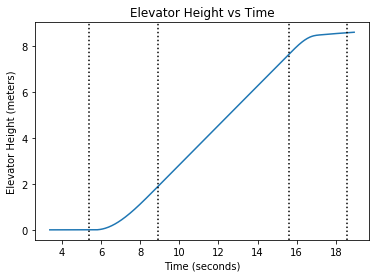

In [39]:
OFFSET = 0.12

plt.title("Elevator Height vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Elevator Height (meters)")

displacements = double_integral(a_z, t, OFFSET)
plt.plot(t[2:], displacements)

# vertical lines
region_delimiters = [5.4, 8.9, 15.6, 18.6]
for x_val in region_delimiters:
    plt.axvline(x=x_val, color="black",linestyle='dotted')

plt.show()

####  Parallel Parking

Same walkthrough, different data. Note that this time the accelerometer is "perfect" (because the data here is faked) and we will be using the `bias` parameter to *introduce* bias (instead of *correcting* it).

In [45]:
from src.helpers import process_data

PARALLEL_PARK_DATA = process_data("./data/parallel_park.pickle")

TIMESTAMPS    = [row[0] for row in PARALLEL_PARK_DATA]
DISPLACEMENTS = [row[1] for row in PARALLEL_PARK_DATA]
YAW_RATES     = [row[2] for row in PARALLEL_PARK_DATA]
ACCELERATIONS = [row[3] for row in PARALLEL_PARK_DATA]

#### Observing the Effects of bias
Run the code cell below. You'll see that when bias is really small (like 0.01), the reported acceleration (blue dots) agrees very well with the actual acceleration (orange dots).

When bias is increased, things get bad fast!

0.01


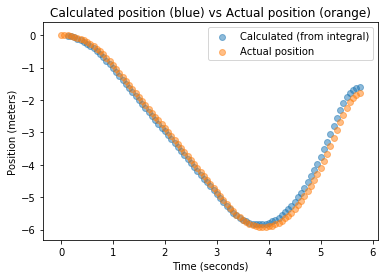

In [46]:
# Try running this cell with BIAS set to 0.01, 0.05, 0.1, 0.2, 0.4
# and so on. Even though these are all small numbers the effect of 
# bias tends to accumulate as the sensor runs for longer and longer.

BIAS = 0.01

integrated_displacements = double_integral(ACCELERATIONS, TIMESTAMPS, BIAS)

plt.title("Calculated position (blue) vs Actual position (orange)")
plt.xlabel("Time (seconds)")
plt.ylabel("Position (meters)")
plt.scatter(TIMESTAMPS[2:], integrated_displacements, alpha=0.5)
plt.scatter(TIMESTAMPS, DISPLACEMENTS, alpha=0.5)
plt.legend(["Calculated (from integral)", "Actual position"])
plt.show()

#### Within the integral, the error or the bias can affect a lot of!!!!!!!!